In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import time

from dataset import SyntheticTimeSeriesDataset
from models.mlp import MLPDenoiser
from models.transformer import TransformerDenoiser
from models.unet import UNet1D
from noise_scheduler import NoiseScheduler
from diffusion import TimeSeriesDDPM
from train import train_model
from evaluation import evaluate_model

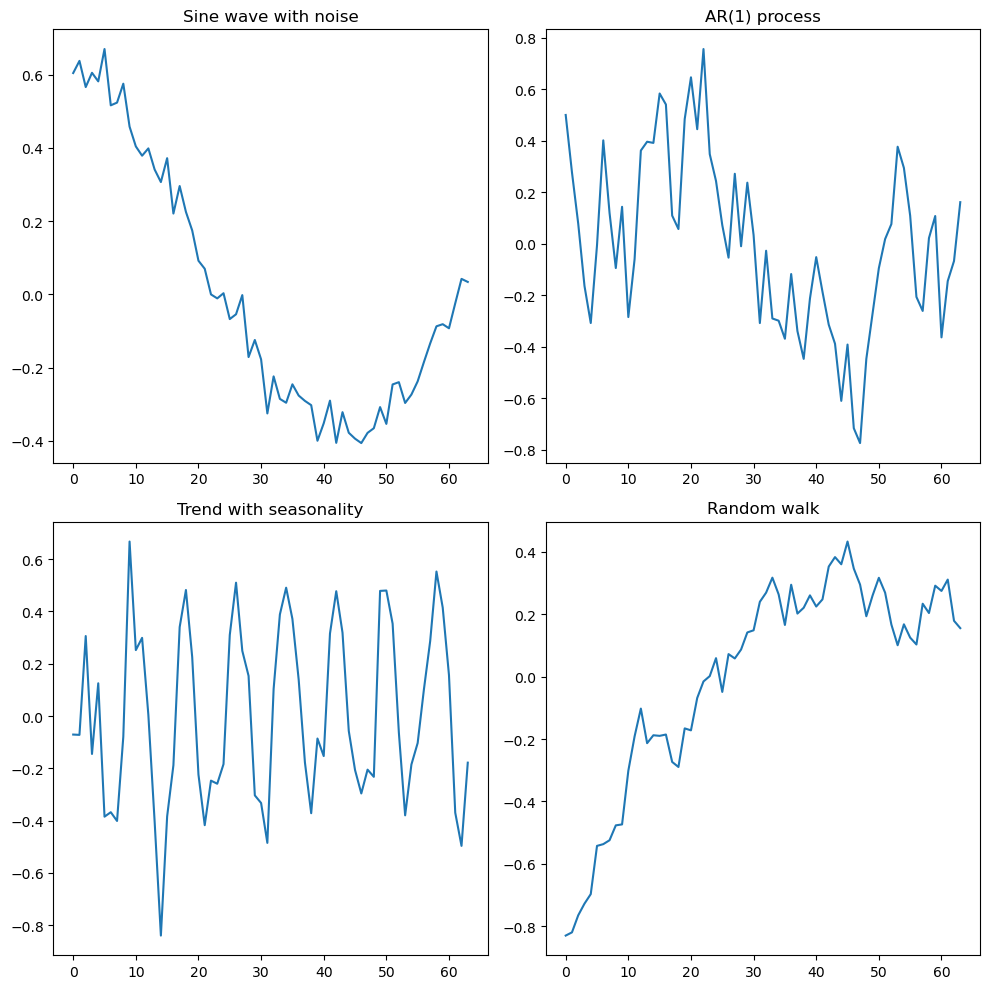

In [2]:
seq_lenght = 64
condition_lenght = 48
num_samples = 128
task = 'forecasting'

# Create dataset
dataset = SyntheticTimeSeriesDataset(num_samples=num_samples,
                                     seq_length=seq_lenght,
                                     condition_length=condition_lenght,
                                     task_type=task)

fig, axes = plt.subplots(2, 2, figsize=(10,10))
titles = [
    'Sine wave with noise',
    'AR(1) process',
    'Trend with seasonality',
    'Random walk'
]

for i, ax in enumerate(axes.flatten()):
    ax.plot(dataset[i]['full_series'])
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

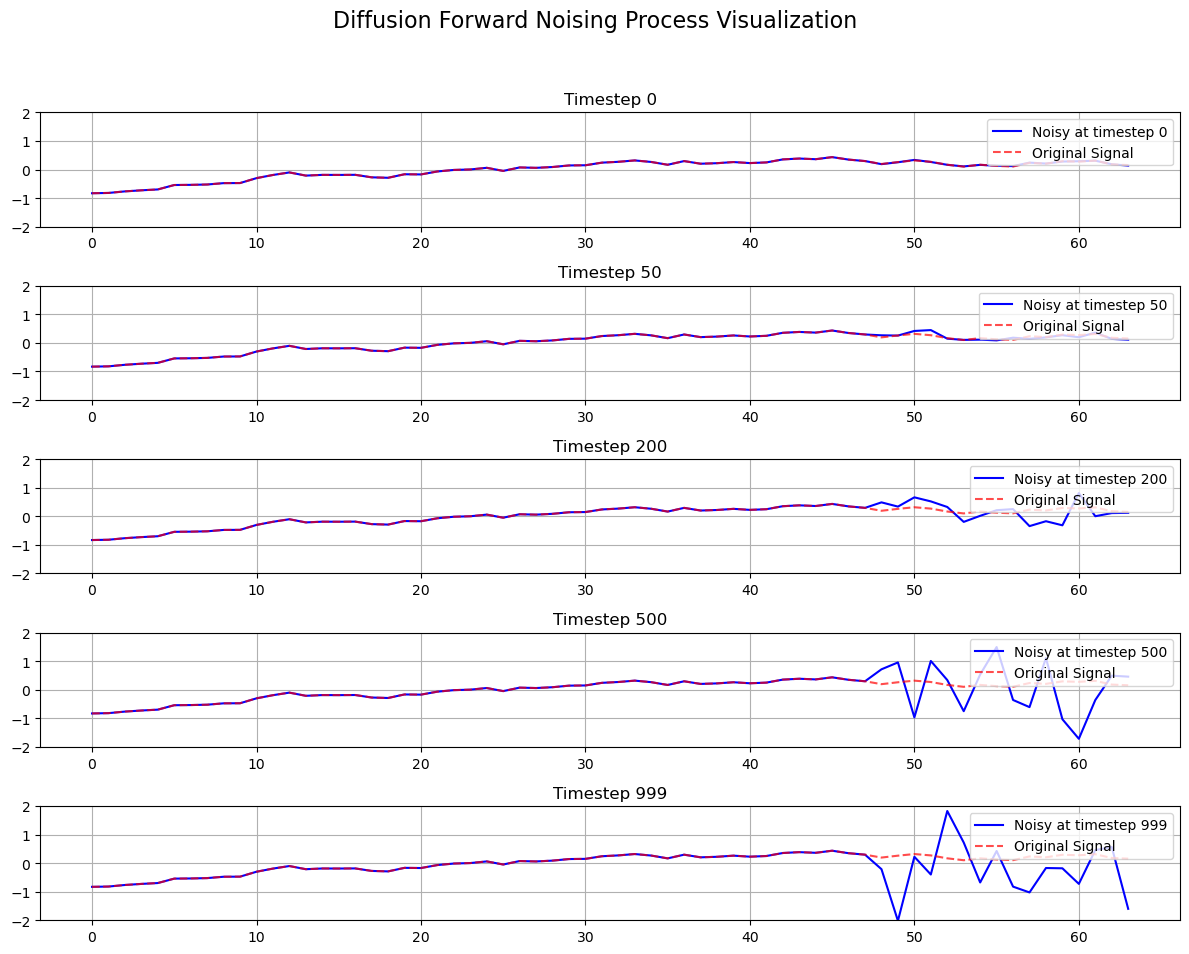

In [3]:
from util import visualize_forward_diffusion

scheduler = NoiseScheduler(num_timesteps=1000, beta_start=1e-4, beta_end=0.02, schedule_type='cosine')

# Generate a clean synthetic 1D signal: sine wave
clean_signal = dataset[3]['full_series']
mask = dataset[3]['mask']

# Visualize noise addition for a few selected timesteps
timesteps_to_show = [0, 50, 200, 500, 999]  # from clean to very noisy

# Call the visualization function
visualize_forward_diffusion(scheduler, clean_signal, mask, timesteps_to_show)


In [4]:
batch_size = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
batch = next(iter(dataloader))
print(f"batch['full_series].shape: {batch['full_series'].shape}")
print(f"batch['condition'].shape: {batch['condition'].shape}")
print(f"batch['target'].shape: {batch['target'].shape}")
print(f"batch['mask'].shape: {batch['mask'].shape}")

batch['full_series].shape: torch.Size([4, 64])
batch['condition'].shape: torch.Size([4, 64])
batch['target'].shape: torch.Size([4, 16])
batch['mask'].shape: torch.Size([4, 64])


# Unet1D

In [5]:
# --- Configuration ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Dataset and training parameters
seq_lenght = 64
condition_lenght = 48
num_samples = 128
batch_size = 4
num_epochs = 5
learning_rate = 0.001

# --- Task Definition ---
task_type = 'forecasting'
# --- Dataset Setup ---
# Create the synthetic time series dataset
dataset = SyntheticTimeSeriesDataset()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# --- Model Initialization ---
# Define the denoiser architecture
arch_name = 'UNET1d'
denoiser = UNet1D(
        model_channels=64,
        num_res_blocks=2,
        attention_resolutions=(2, 4),
        channel_mult=(1, 2, 4),
        num_heads=4
    ).to(device)

# Count and display the number of trainable parameters in the denoiser
num_params = sum(p.numel() for p in denoiser.parameters() if p.requires_grad)
print(f"Denoiser model parameters: {num_params:,}")

# Initialize the noise scheduler
noise_scheduler = NoiseScheduler(num_timesteps=1000, schedule_type='linear')

# Create the Denoising Diffusion Probabilistic Model (DDPM)
ddpm_model = TimeSeriesDDPM(denoiser, noise_scheduler, device=device)

# --- Model Training ---
print(f"Starting Training for {arch_name} on {task_type}")

# Train the DDPM model
training_losses = train_model(
    ddpm_model,
    dataloader,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    device=device
)

Using device: cpu
Denoiser model parameters: 9,737,089
Starting Training for UNET1d on forecasting


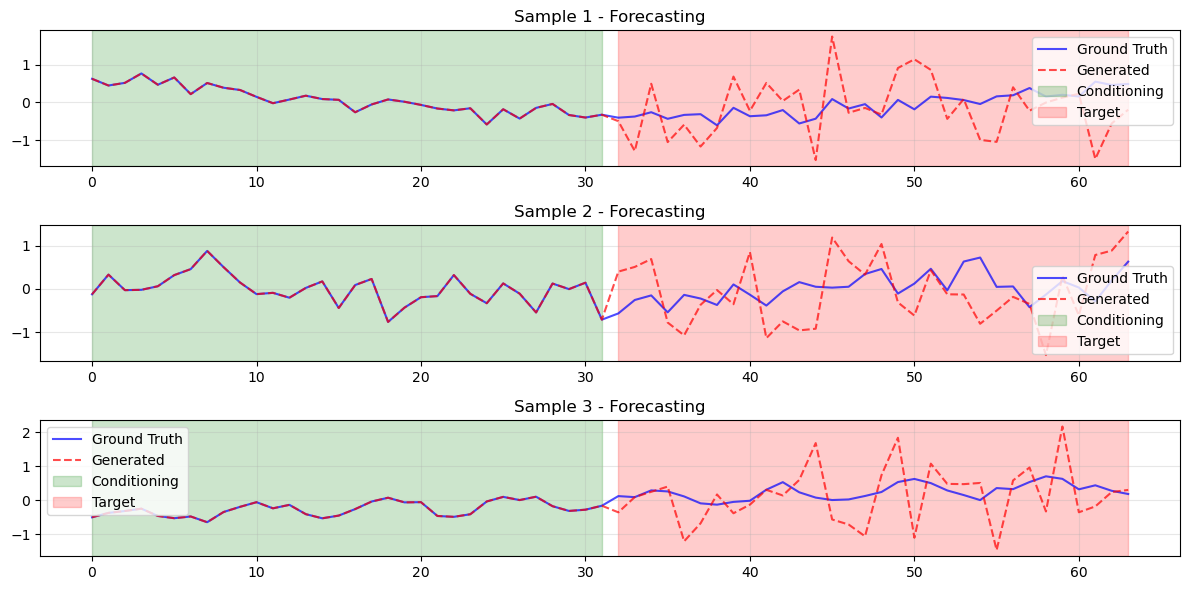

In [6]:
evaluate_model(ddpm_model, dataset, num_samples=3, num_inference_steps=50)